In [6]:
import xarray as xr
import numpy as np
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/workspace/bkraft/dl_chapter14/src')
from utils.plotting import plot_map, subplots_robinson, plot_scatter, plot_hist2d, plot_hexbin
from utils.metrics import get_metrics

### Data

In [98]:
dss = xr.open_zarr('/scratch/dl_chapter14/experiments/hydro/default/pred/predictions_so.zarr/')
dst = xr.open_zarr('/scratch/dl_chapter14/experiments/hydro/default/pred/predictions_to.zarr/')

ValueError: supplied range of [nan, nan] is not finite

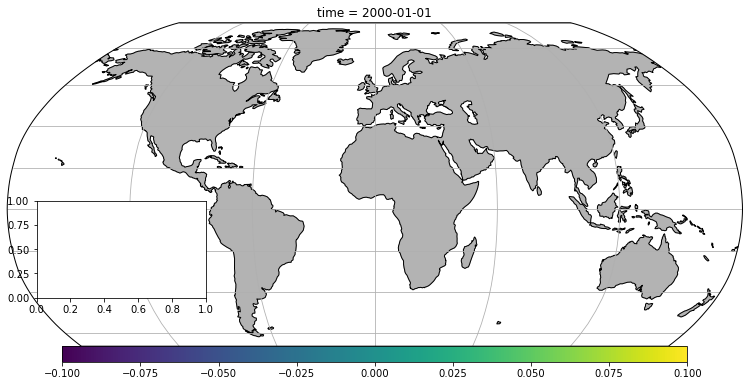

In [99]:
%time plot_map(dss.mod.isel(time=0)-dss.obs.isel(time=0), robust=True)

CPU times: user 15.6 s, sys: 3.84 s, total: 19.4 s
Wall time: 6.54 s


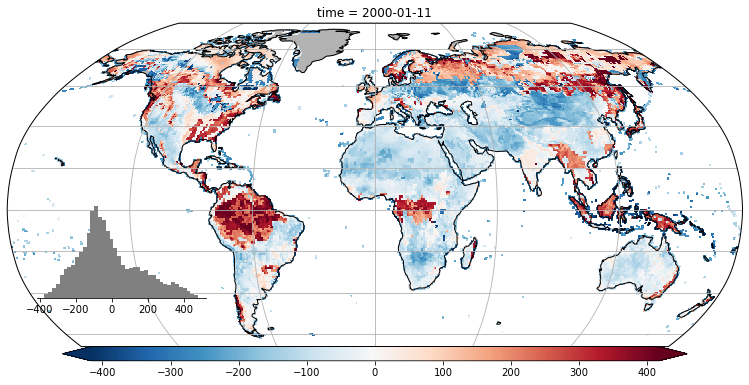

In [95]:
%time plot_map(dst.obs.isel(time=10)-dss.mod.isel(time=10), robust=True)

### Spatial analysis

In [96]:
met = get_metrics(dst.mod, dst.obs, ['corr', 'rmse', 'mef'])

11/13/2019, 09:42:40: calculating metrics [corr, rmse, mef]
11/13/2019, 09:42:40: - corr


/opt/conda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/workspace/bkraft/dl_chapter14/src/utils/metrics.py:34: RuntimeWarning: invalid value encountered in true_divide
  cov = np.nansum(x * y, axis=-1) / valid_count
/workspace/bkraft/dl_chapter14/src/utils/metrics.py:32: RuntimeWarning: Mean of empty slice
  y -= np.nanmean(y, axis=-1, keepdims=True)


11/13/2019, 09:42:56: - rmse
11/13/2019, 09:43:05: - mef
11/13/2019, 09:43:16: done; elapsed time: 0 min 35 sec


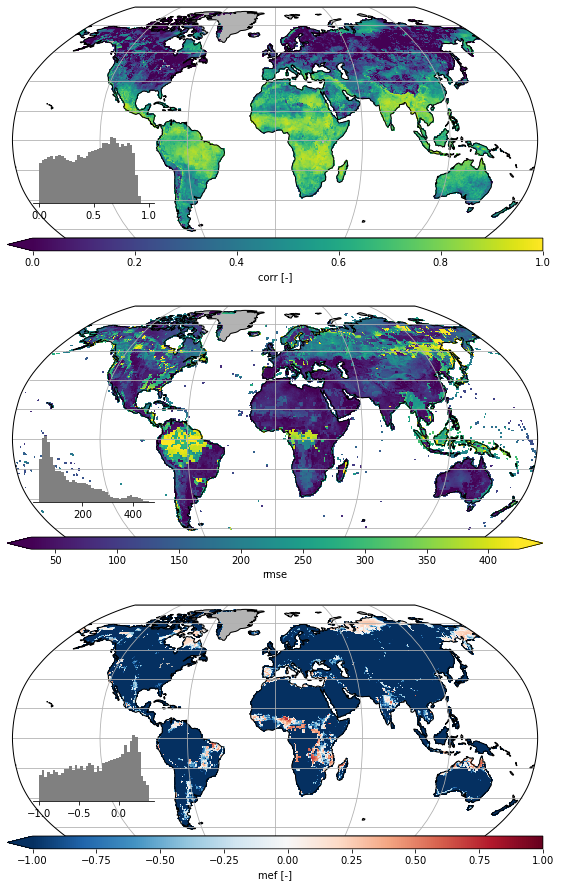

In [97]:
fig, axes = subplots_robinson(3, 1, figsize=(12, 16), gridspec_kw={'hspace': 0.1})

plot_map(met.corr, vmin=0, vmax=1, ax=axes[0])
plot_map(met.rmse, robust=True, ax=axes[1])
plot_map(met.mef, vmin=-1, robust=True, ax=axes[2])

In [90]:
def plot_time_series(
        x, y,
        xlabel='mod', ylabel='obs',
        timeagg=None,
        title='',
        ax=None,
        figsize=(15, 5),
        subplot_kw={},
        **kwargs):

    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.subplot(**subplot_kw)

    if timeagg is not None:
        x = x.resample(time=timeagg).mean()
        y = y.resample(time=timeagg).mean()

    time = x.time.values

    x_m = x.mean(dim=['lat', 'lon'])
    y_m = y.mean(dim=['lat', 'lon'])

    x_qs = xr_quantile(x, [0.25, 0.75], dim=['lat', 'lon'])
    y_qs = xr_quantile(y, [0.25, 0.75], dim=['lat', 'lon'])

    ax.fill_between(time, x_qs.isel(quantile=0), x_qs.isel(quantile=1), alpha=0.2, facecolor='tab:blue', label=r'$modeled_{q0.2-0.8}$')
    ax.fill_between(time, y_qs.isel(quantile=0), y_qs.isel(quantile=1), alpha=0.2, facecolor='k', label=r'$observed_{q0.2-0.8}$')
    ax.plot(time, x_m, alpha=1.0, color='tab:blue', linewidth=2., label=r'$modeled_{median}$')
    ax.plot(time, y_m, color='k', linewidth=1.2, linestyle='--', label=r'$observed_{median}$')

    # ax.text(0.05, 0.95, f'r={r:.3f}', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
    
    # ax.set_ylabel(var)

    ax.patch.set_facecolor('white')

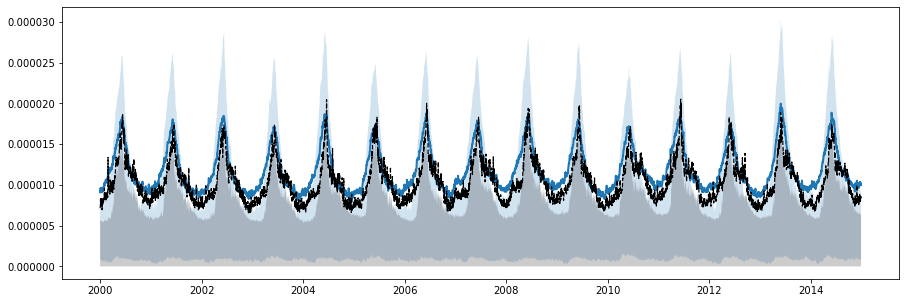

In [91]:
plot_time_series(dss.mod, dss.obs)

In [79]:
def _single_xr_quantile(x, q, dim):
    if isinstance(dim, str):
        dim = [dim]
    ndims = len(dim)
    axes = tuple(np.arange(ndims)-ndims)
    m = xr.apply_ufunc(
        np.nanquantile, x,
        input_core_dims=[dim],
        dask='parallelized',
        output_dtypes=[float],
        keep_attrs=True,
        kwargs={'q': q, 'axis': axes})
    m.name = 'quantile'
    return m

def xr_quantile(x, q, dim):
    if not hasattr([1, 2], '__iter__'):
        q = [q]
    quantiles = []
    for i, q_ in enumerate(q):
        r = _single_xr_quantile(x, q_, dim).compute()
        quantiles.append(r)
    quantiles = xr.concat(quantiles, 'quantile')
    quantiles['quantile'] = q
    quantiles.attrs.update({**x.attrs})


    return quantiles

In [80]:
qs = xr_quantile(dss.obs, [0.25, 0.5, 0.75], dim=['lat', 'lon'])

In [84]:
qs

<xarray.DataArray 'quantile' (quantile: 3, time: 5478)>
array([[1.83738948e-10, 2.04982260e-10, 2.16509324e-10, ...,
        2.74700290e-10, 2.71642167e-10, 2.85568819e-10],
       [5.45322166e-07, 5.53611130e-07, 5.48898129e-07, ...,
        5.88953355e-07, 6.00083808e-07, 6.16812031e-07],
       [5.49330184e-06, 5.59299383e-06, 5.64336187e-06, ...,
        6.35672814e-06, 6.31667422e-06, 6.43782687e-06]])
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2014-12-30
  * quantile  (quantile) float64 0.25 0.5 0.75
Attributes:
    long_name:  Total runoff
    units:      kg/m2/s

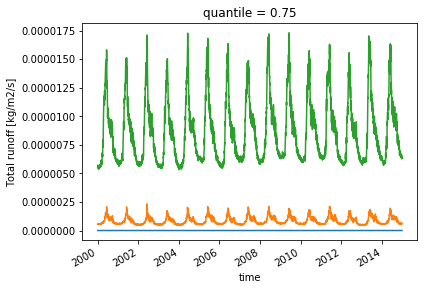

In [85]:
qs.isel(quantile=0).plot()
qs.isel(quantile=1).plot()
qs.isel(quantile=2).plot()

In [55]:
med.

<xarray.DataArray 'rmse' (time: 5478)>
array([5.45322166e-07, 5.53611130e-07, 5.48898129e-07, ...,
       5.88953355e-07, 6.00083808e-07, 6.16812031e-07])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2014-12-30
Attributes:
    long_name:  rmse
    units:      kg/m2/s

In [49]:
xr.merge(qs)

MergeError: conflicting values for variable 'rmse' on objects to be combined. You can skip this check by specifying compat='override'.

In [44]:
med = xr_quantile(dss.obs, [0.25, 0.75], dim=['lat', 'lon']).compute()

ValueError: replacement data must match the Variable's shape

In [ ]:
plt.plot(med)

In [16]:
med = xr_median(dst.obs, dim=['time']).compute()

['lat', 'lon']


/opt/conda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:994: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


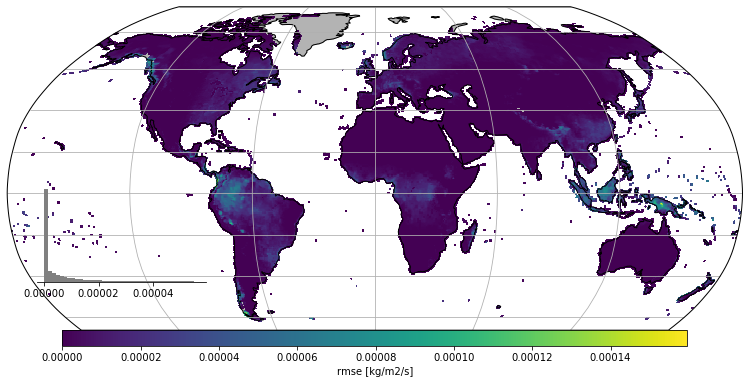

In [19]:
plot_map(med)

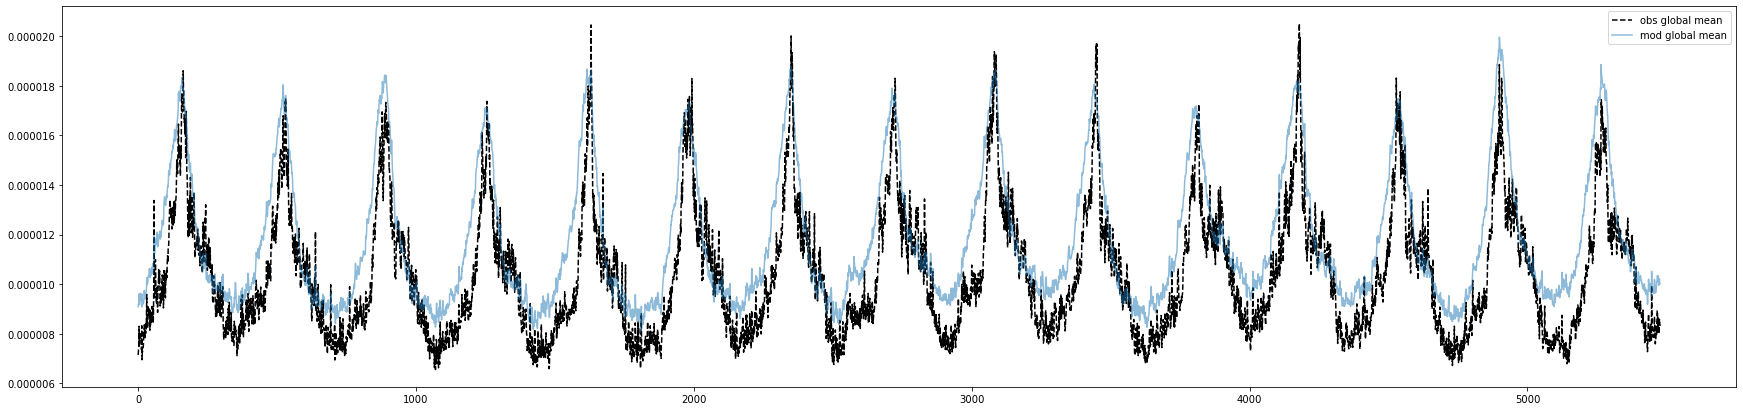

In [40]:
plt.figure(figsize=(30, 7))

plt.plot(dss.obs.mean(('lat', 'lon')), 'k--', label='obs global mean')
plt.plot(dss.mod.mean(('lat', 'lon')), alpha=0.5, label='mod global mean')
plt.legend()

In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [114]:
def f0(x):
    return x**(-0.5)
def f1(x):
    return x**(-0.2) + 0.01 * x
def f_gl(x):
    gl = np.zeros_like(x)
    for t, v in enumerate(x):
        gl[t] = 100 * (v / np.min(x[:t+1]) - 1)
    return gl
def f_min(x):
    m = np.zeros_like(x)
    for t, v in enumerate(x):
        m[t] = np.min(x[:t+1])
    return m

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


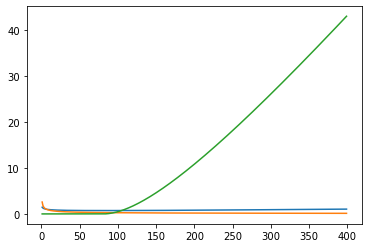

In [124]:
t = np.linspace(0, 60, 400)
e_tr = f0(t)
e_va = f1(t)
gl = f_gl(e_va)
gl_tr = f_gl(e_tr)
plt.plot(e_va)
plt.plot(e_tr)
plt.plot(gl)
# plt.plot(gl_tr)

In [141]:
def f_gl(x):
    per_impr = np.zeros_like(x)
    for t in range(1, len(x)):
        per_impr[t] = 100 * (1 - x[t] / x[t-1])
    return per_impr

In [142]:
gl = f_gl(e_va)

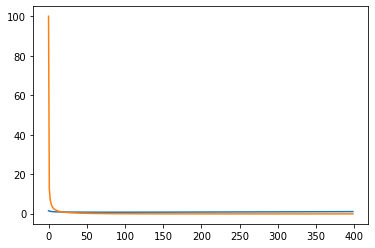

In [143]:
plt.plot(e_va[1:])
plt.plot(gl[1:])

In [25]:
import pandas as pd

In [27]:
df = pd.read_csv('/scratch/dl_chapter14/experiments/hydro/default/cv/hydro/Emulator_0_2019-11-11_08-42-07m_hccusr/progress.csv')

EmptyDataError: No columns to parse from file

In [199]:
df

,epoch,loss_train,loss_eval,patience_counter,perc_improved,best_loss,done,timesteps_total,episodes_total,training_iteration,...,timestamp,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,trial_id
0,1,1.300028e-09,5.944167e-10,0,0.000000,5.944167e-10,False,NaN,NaN,1,...,1573404119,95.269621,95.269621,12967,8d43effa4b71,172.17.0.6,95.269621,0,1,c3511f40
1,2,1.309272e-09,5.815003e-10,0,2.172953,5.815003e-10,False,NaN,NaN,2,...,1573404213,94.573489,189.843110,12967,8d43effa4b71,172.17.0.6,189.843110,0,2,c3511f40
2,3,1.274369e-09,5.733385e-10,0,1.403578,5.733385e-10,False,NaN,NaN,3,...,1573404309,95.571095,285.414205,12967,8d43effa4b71,172.17.0.6,285.414205,0,3,c3511f40
3,4,1.194475e-09,5.709449e-10,0,0.417483,5.709449e-10,False,NaN,NaN,4,...,1573404405,96.205045,381.619250,12967,8d43effa4b71,172.17.0.6,381.619250,0,4,c3511f40
4,5,1.250227e-09,5.724166e-10,1,-0.257755,5.709449e-10,False,NaN,NaN,5,...,1573404501,95.896864,477.516114,12967,8d43effa4b71,172.17.0.6,477.516114,0,5,c3511f40
5,6,1.119440e-09,5.715308e-10,2,-0.102611,5.709449e-10,False,NaN,NaN,6,...,1573404596,94.940071,572.456184,12967,8d43effa4b71,172.17.0.6,572.456184,0,6,c3511f40
6,7,1.130880e-09,5.606235e-10,0,1.807775,5.606235e-10,False,NaN,NaN,7,...,1573404692,95.375186,667.831370,12967,8d43effa4b71,172.17.0.6,667.831370,0,7,c3511f40
7,8,1.091978e-09,5.612418e-10,1,-0.110277,5.606235e-10,False,NaN,NaN,8,...,1573404786,94.430029,762.261399,12967,8d43effa4b71,172.17.0.6,762.261399,0,8,c3511f40
8,9,9.497963e-10,5.516027e-10,0,1.609082,5.516027e-10,False,NaN,NaN,9,...,1573404881,94.711263,856.972662,12967,8d43effa4b71,172.17.0.6,856.972662,0,9,c3511f40
9,10,9.247447e-10,5.443904e-10,0,1.307516,5.443904e-10,False,NaN,NaN,10,...,1573404976,94.985668,951.958331,12967,8d43effa4b71,172.17.0.6,951.958331,0,10,c3511f40


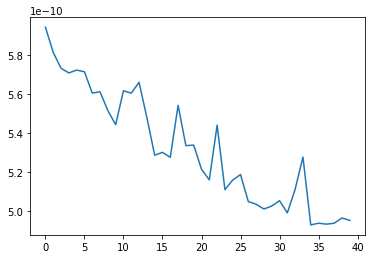

In [200]:
plt.plot(df['loss_eval'])

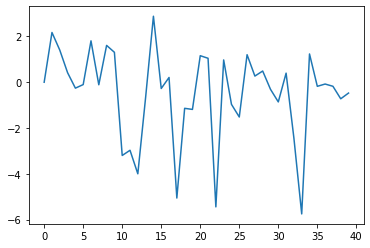

In [201]:
plt.plot(df['perc_improved'])

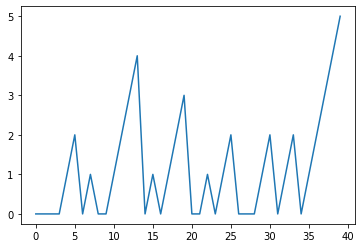

In [202]:
plt.plot(df['patience_counter'])

In [23]:
l = {'a': 1, 'b': 2}
options_str = ", ".join(l.keys())
print(f'[{options_str}]')

[a, b]


'a, b'

In [30]:
print(f'{getattr.__name__}')

getattr


In [31]:
from datetime import datetime

In [33]:
tic = datetime.now()

In [34]:
tic.strftime("%m/%d/%Y, %H:%M:%S")

'11/11/2019, 09:38:00'

In [35]:
toc = datetime.now()

In [42]:
elapsed = toc- tic

In [43]:
elapsed.seconds

302

In [45]:
mins = int(elapsed.seconds/60)
mins

5

In [46]:
secs = int(elapsed.seconds - 60 * mins)
secs

2

In [3]:
import xarray as xr
import numpy as np
import zarr

In [11]:
ds_ssd = zarr.open_group('/scratch/dl_chapter14/experiments/hydro/default/pred/predictions.zarr/')
ds_ram = zarr.open_group('/run/user/196')
ds_ram.tree()

/
 ├── lat (360,) float32
 ├── lon (720,) float32
 ├── mrro (5478, 360, 720) float32
 ├── mrro_obs (5478, 360, 720) float32
 └── time (5478,) int64

In [14]:
def read_zarr(ds, n):
    for i in range(n):
        lat = np.random.choice(360)
        lon = np.random.choice(720)
        s = ds['mrro'][:, lat, lon] + 1

In [15]:
%time read_zarr(ds_ssd, 1000)

CPU times: user 300 ms, sys: 2.21 s, total: 2.51 s
Wall time: 2.5 s


In [16]:
%time read_zarr(ds_ssd, 1000)

CPU times: user 288 ms, sys: 2.27 s, total: 2.56 s
Wall time: 2.55 s


In [17]:
ls -l /run/user/1968

ls: cannot access '/run/user/1968': No such file or directory


In [ ]:
/scratch/

In [6]:
import torch
import numpy as np

In [8]:
class RNN(torch.nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = torch.nn.RNN(1, 5)
    def forward(self, x):
        out = self.rnn(x)
        return out


In [2]:
import xarray as xr

In [3]:
ds = xr.open_zarr('/scratch/dl_chapter14/experiments/hydro/default/pred/predictions.zarr/')

In [45]:
ds

<xarray.DataArray 'rzwc' (time: 23741, lat: 360, lon: 720)>
dask.array<zarr, shape=(23741, 360, 720), dtype=float32, chunksize=(23741, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2014-12-31
Attributes:
    long_name:  Root zone soil moisture
    units:      kg/m2

In [ ]:
pred = xr.Dataset({
    'obs': xr.DataArray(ds.values, coords=[ds.lat, ds.lon, ds.time]),
    'mod': xr.DataArray(ds.values, coords=[ds.lat, ds.lon, ds.time])
})
pred.attrs = ds.attrs

In [30]:
xr.Dataset({
    'mod': xr.DataArray(ds.mrro.values, coords=[dslat, ds.lon, ds.time),
    'obs': xr.ones_like(ds.coords) * ds.mrro.values
})

TypeError: Expected DataArray, Dataset, or Variable

In [21]:
ds

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 5478)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2014-12-30
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
Data variables:
    mrro     (time, lat, lon) float32 dask.array<chunksize=(5478, 10, 10), meta=np.ndarray>
Attributes:
    citation:     Koirala, Sujan, et al. Global-scale land surface hydrologic...
    contact:      Sujan Koirala <skoirala@bgc-jena.mpg.de> and Hyungjun Kim <...
    experiment:   SP-MIP: Experiment No. 3
    forcing:      GSWP-3 sub-daily
    institution:  Max-Planck-Institute for Biogeochemistry, Jena, Germany; Th...
    model:        MATSIRO LSM with GW Representation
    project:      Soil Parameter Model Intercomparison Project (SP-MIP): Asse...

In [36]:
ds = xr.open_zarr('/scratch/dl_chapter14/target/dynamic/koirala2017.zarr/')
ds

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 23741)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2014-12-31
Data variables:
    et       (time, lat, lon) float32 dask.array<chunksize=(23741, 10, 10), meta=np.ndarray>
    mrro     (time, lat, lon) float32 dask.array<chunksize=(23741, 10, 10), meta=np.ndarray>
    rzwc     (time, lat, lon) float32 dask.array<chunksize=(23741, 10, 10), meta=np.ndarray>
    tws      (time, lat, lon) float32 dask.array<chunksize=(23741, 10, 10), meta=np.ndarray>
    wtd      (time, lat, lon) float32 dask.array<chunksize=(23741, 10, 10), meta=np.ndarray>
Attributes:
    citation:     Koirala, Sujan, et al. Global-scale land surface hydrologic...
    contact:      Sujan Koirala <skoirala@bgc-jena.mpg.de> and Hyungjun Kim <...
    experiment:   SP-MIP: Experiment No. 3
 

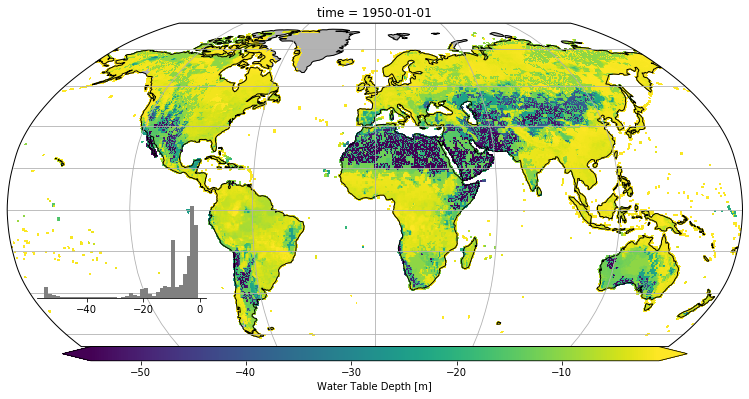

In [39]:
plot_map(ds.wtd.isel(time=0), robust=True)

In [113]:
p = xr.open_zarr('/scratch/hydrodl/data/bucket.zarr/prec/')

In [117]:
p_missing = p.data.isnull().sum('time').compute()

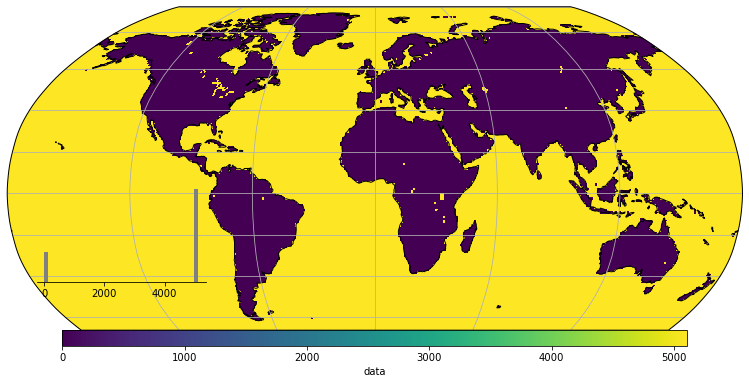

In [119]:
plot_map(p_missing)

In [120]:
xr.open_zarr('/scratch/dl_chapter14/target/dynamic/koirala2017.zarr/')

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 23741)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2014-12-31
Data variables:
    et       (time, lat, lon) float32 dask.array<chunksize=(23741, 10, 10), meta=np.ndarray>
    mrro     (time, lat, lon) float32 dask.array<chunksize=(23741, 10, 10), meta=np.ndarray>
    rzwc     (time, lat, lon) float32 dask.array<chunksize=(23741, 10, 10), meta=np.ndarray>
    tws      (time, lat, lon) float32 dask.array<chunksize=(23741, 10, 10), meta=np.ndarray>
    wtd      (time, lat, lon) float32 dask.array<chunksize=(23741, 10, 10), meta=np.ndarray>
Attributes:
    citation:     Koirala, Sujan, et al. Global-scale land surface hydrologic...
    contact:      Sujan Koirala <skoirala@bgc-jena.mpg.de> and Hyungjun Kim <...
    experiment:   SP-MIP: Experiment No. 3
 

In [133]:
xr.open_dataset('/workspace/BGI/people/skoirala/spmip/matsiro-gw.run1_20180805/matsiro-gw_experiment_1_1982.nc')

<xarray.Dataset>
Dimensions:    (lat: 360, level: 13, lon: 720, time: 366)
Coordinates:
  * lat        (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon        (lon) float32 0.25 0.75 1.25 1.75 ... -1.75 -1.25 -0.75 -0.25
  * time       (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1983-01-01
  * level      (level) int32 5 20 75 100 100 100 100 100 100 100 100 100 3000
Data variables:
    rss        (time, lat, lon) float32 ...
    hfss       (time, lat, lon) float32 ...
    ec         (time, lat, lon) float32 ...
    ts         (time, lat, lon) float32 ...
    hfls       (time, lat, lon) float32 ...
    et         (time, lat, lon) float32 ...
    cw         (time, lat, lon) float32 ...
    es         (time, lat, lon) float32 ...
    tsl        (time, level, lat, lon) float32 ...
    hfdss      (time, lat, lon) float32 ...
    tws        (time, lat, lon) float32 ...
    mrrob      (time, lat, lon) float32 ...
    albsrfc    (time, lat, lon) float32 ...
    snc  

In [134]:
ds_frac = xr.open_dataset('/workspace/BGI/people/skoirala/spmip/matsiro-gw.run1_20180805/matsiro-gw_experiment_1_1982.nc')['mrlslfrac']
ds = xr.open_dataset('/workspace/BGI/people/skoirala/spmip/matsiro-gw.run1_20180805/matsiro-gw_experiment_1_1982.nc')['rzwc']

In [135]:
ds

<xarray.DataArray 'rzwc' (time: 366, lat: 360, lon: 720)>
[94867200 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... -1.75 -1.25 -0.75 -0.25
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1983-01-01
Attributes:
    long_name:  Root zone soil moisture
    units:      kg/m2

In [124]:
ds_frac_mean = ds_frac.mean(('time', 'level'))
ds_mean = ds.mean(('time', 'level'))

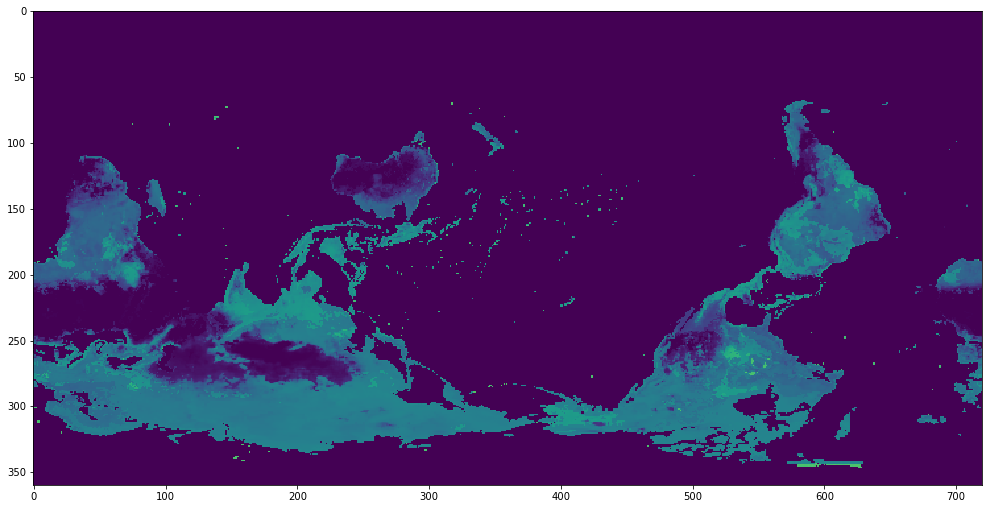

In [130]:
plt.figure(figsize=(17, 12))
plt.imshow(ds_frac_mean.values, vmin=0.2, vmax=0.6)

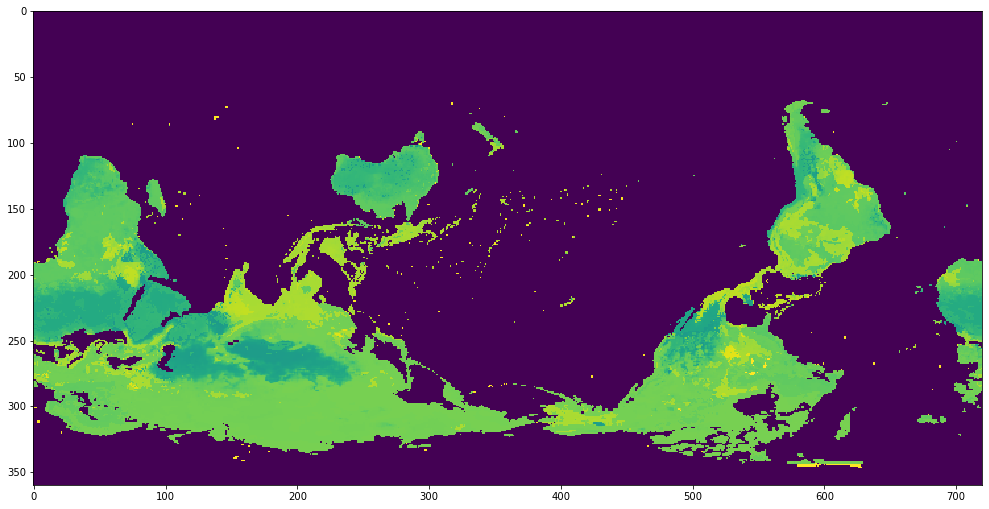

In [132]:
plt.figure(figsize=(17, 12))
plt.imshow(ds_mean.values)

In [ ]:
plot_map(ds_mean)

In [ ]:
"et", "tws", "mrro", "wtd", "mrlslfrac"

In [20]:
t = xr.open_dataset('/workspace/BGI/people/skoirala/spmip/full_matsiro-gw_exp3.run1_20180805_latlonReverse/full_matsiro-gw_exp3_experiment_3_1950.nc')

In [29]:
t

<xarray.Dataset>
Dimensions:    (lat: 360, levelc: 13, levelf: 14, lon: 720, time: 366)
Coordinates:
  * lat        (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon        (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 1951-01-01
  * levelf     (levelf) int32 0 5 25 100 200 300 ... 600 700 800 900 1000 4000
  * levelc     (levelc) int32 5 20 75 100 100 100 100 100 100 100 100 100 3000
Data variables:
    rss        (time, lat, lon) float32 ...
    hfss       (time, lat, lon) float32 ...
    gwrec      (time, lat, lon) float32 ...
    ec         (time, lat, lon) float32 ...
    ts         (time, lat, lon) float32 ...
    hfls       (time, lat, lon) float32 ...
    et         (time, lat, lon) float32 ...
    cw         (time, lat, lon) float32 ...
    es         (time, lat, lon) float32 ...
    tsl        (time, levelc, lat, lon) float32 ...
    hfdss      (time, lat, lon) float32 ...
   

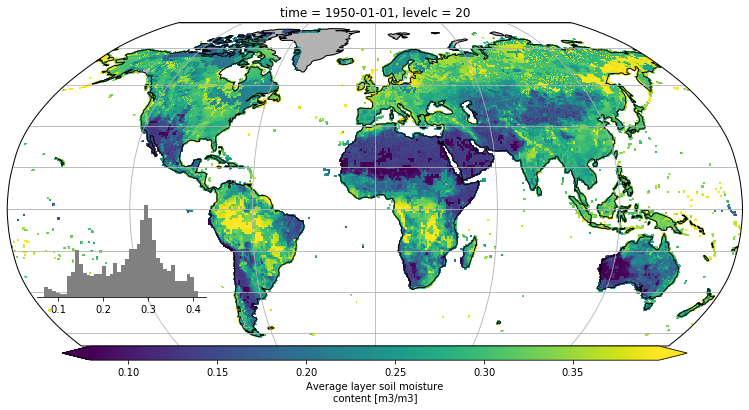

In [26]:
plot_map(t.mrlslfrac.isel(levelc=1, time=0), robust=True)

In [17]:
ls -l /workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/

total 144
drwxrwxr-x 2 895 545 8194 Dec 17  2018 ET/
drwxrwxr-x 2 895 545 8193 Dec 17  2018 IWA/
drwxrwxr-x 2 895 545 8193 Aug 21  2018 LWdown/
drwxrwxr-x 2 895 545 8193 Dec 17  2018 PET_PT/
drwxrwxr-x 2 895 545 8193 Aug 21  2018 PSurf/
drwxrwxr-x 2 895 545 8193 Dec 17  2018 Precip/
drwxrwxr-x 2 895 545 8193 Dec 14  2018 Qair/
drwxrwxr-x 2 895 545 8193 Aug 24  2018 Rainf/
drwxrwxr-x 2 895 545 8193 Dec 17  2018 Rh/
drwxrwxr-x 2 895 545 8193 Dec 17  2018 Rn/
drwxrwxr-x 2 895 545 8193 Aug 21  2018 SWdown/
drwxrwxr-x 2 895 545 8193 Aug 24  2018 Snowf/
drwxrwxr-x 2 895 545 8193 Aug 21  2018 Tair/
drwxrwxr-x 2 895 545 8193 Aug 21  2018 Tmax/
drwxrwxr-x 2 895 545 8193 Aug 21  2018 Tmin/
drwxrwxr-x 2 895 545 8193 Dec 17  2018 WAI1/
drwxrwxr-x 2 895 545 8193 Dec 17  2018 WAI2/
drwxrwxr-x 2 895 545 8193 Aug 24  2018 Wind/


In [ ]:
e


#### input vars

| var  | dims | path |
| ---  | ---  | ---  |
| Rainf  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Rainf/' |
| Snowf  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Snowf/' |
| SWdown  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/SWdown/' |
| LWdown  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/LWdown/' |
| Tair  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Tair/' |
| Wind  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Wind/' |
| Qair  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Qair/' |
| PSurf  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/PSurf/' |
| lai | lat, lon, time | '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_lai.nc' |
| ccover | lat, lon, time | '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_lai.nc' |
| PFT | lat, lon | '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_PFT.nc' |
| soil_properties | lat, lon | '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_soil_propreties.nc' |

#### Target vars

| var  | dims | path |
| ---  | ---  | ---  |
| et (also input) | lat, lon, time | '/workspace/BGI/people/skoirala/spmip/full_matsiro-gw_exp3.run1_20180805_latlonReverse/full_matsiro-gw_exp3_experiment_3_YYYY.nc' |
| mrlslfrac (mean of first 4 levels)  | lat, lon, time | '/workspace/BGI/people/skoirala/spmip/full_matsiro-gw_exp3.run1_20180805_latlonReverse/full_matsiro-gw_exp3_experiment_3_YYYY.nc' |
| tws  | lat, lon, time | '/workspace/BGI/people/skoirala/spmip/full_matsiro-gw_exp3.run1_20180805_latlonReverse/full_matsiro-gw_exp3_experiment_3_YYYY.nc' |
| mrro  | lat, lon, time | '/workspace/BGI/people/skoirala/spmip/full_matsiro-gw_exp3.run1_20180805_latlonReverse/full_matsiro-gw_exp3_experiment_3_YYYY.nc' |


In [1]:
import xarray as xr

In [56]:
d = xr.open_dataset('/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_soil_propreties.nc')
d

<xarray.Dataset>
Dimensions:          (latitude: 360, longitude: 720)
Coordinates:
  * latitude         (latitude) float64 -90.0 -89.5 -89.0 ... 88.5 89.0 89.5
  * longitude        (longitude) float64 -180.0 -179.5 -179.0 ... 179.0 179.5
Data variables:
    soil_properties  (latitude, longitude) float32 ...

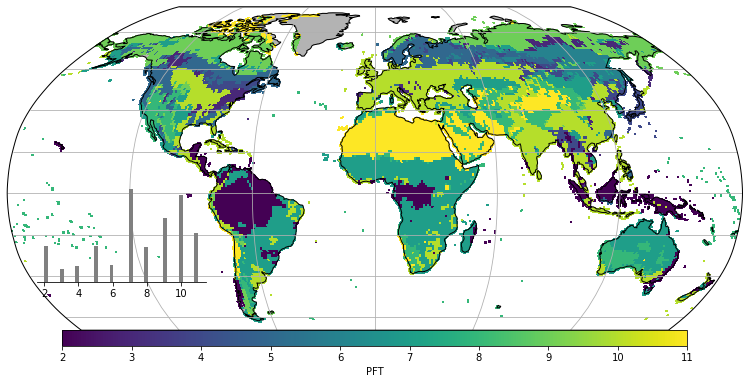

In [16]:
plot_map(d.PFT)